# Intro to Multi-Layer Perceptrons

## Prerequisites

* Neural Networks: https://www.youtube.com/watch?v=aircAruvnKk

* Gradient Descent: https://www.youtube.com/watch?v=IHZwWFHWa-w

* Back-Propagation: https://www.youtube.com/watch?v=Ilg3gGewQ5U

* Back-Propagation (w/ Calculus): https://www.youtube.com/watch?v=tIeHLnjs5U8&t=366s

## Learning Goals

* We will learn to create a MLP using different regularization techniques.

* We will learn to evaluate our choice of architecture and model performance.

-----

## Imports

In [2]:
# pip install torch

     |████████████████████████████████| 81.1MB 6.6MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [4]:
# pip install skorch

     |████████████████████████████████| 112kB 2.5MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

from mlxtend.plotting import plot_decision_regions

import pandas as pd
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F

from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring

from sklearn.datasets import make_moons
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

import gc; gc.enable()

import warnings
warnings.filterwarnings("ignore")

/Users/frkornet/opt/anaconda3/envs/learn/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Toy Dataset

In [6]:
X, y = make_moons(n_samples=500, 
                  shuffle=True, noise=0.25, random_state=42)

df = pd.DataFrame(X, columns=['x', 'y'])
target = 'target'
df[target] = y

del X; del y; gc.collect();

df.head()

,x,y,target
0,0.830948,-0.296546,1
1,1.088387,0.899693,0
2,1.135634,-0.462935,1
3,-0.082277,1.059718,0
4,0.443047,1.418977,0


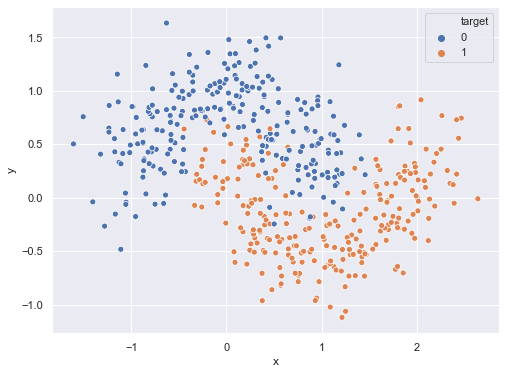

In [7]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['x'], y=df['y'], 
                hue=df[target])
plt.show()

## Simple Baseline

In [8]:
used_cols = [c for c in df.columns.tolist() if c not in [target]]

X, y = df[used_cols].values, df[target].values
baseline = KNN(n_neighbors=10, n_jobs=-1)

scores = cross_val_score(baseline, X, y, cv=5, n_jobs=-1, scoring='roc_auc')
scores.mean(), scores.std()

(0.9825200000000001, 0.009734557000706304)

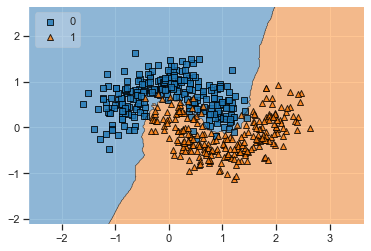

In [9]:
baseline.fit(X, y)
plot_decision_regions(X, y, clf=baseline, legend=2)
plt.show()

# SciKit-Learn Multi-Layer Perceptrons

## One Hidden Layer

In [10]:
mlp_sklearn = MLPClassifier(
    hidden_layer_sizes=(10,),
    activation='logistic',
    solver='lbfgs',
    alpha=1e-2,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.10,
    n_iter_no_change=10,
    tol=1e-4,
    max_iter=200
)

scaler = StandardScaler()
pipe = make_pipeline(scaler, mlp_sklearn)

scores = cross_val_score(pipe, X, y, cv=5, n_jobs=-1, scoring='roc_auc')
scores.mean(), scores.std()

(0.98072, 0.016916548111243032)

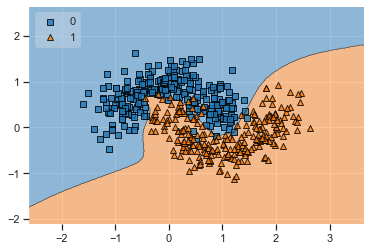

In [11]:
pipe.fit(X, y)
plot_decision_regions(X, y, clf=pipe, legend=2)
plt.show()

## Two Hidden Layers

In [12]:
mlp_sklearn = MLPClassifier(
    hidden_layer_sizes=(10, 20,),
    activation='logistic',
    solver='lbfgs',
    alpha=1e-2,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.10,
    n_iter_no_change=10,
    max_iter=200,
    tol=1e-4
)

scaler = StandardScaler()
pipe = make_pipeline(scaler, mlp_sklearn)

scores = cross_val_score(pipe, X, y, cv=5, n_jobs=-1, scoring='roc_auc')
scores.mean(), scores.std()

(0.9848000000000001, 0.006191607222684618)

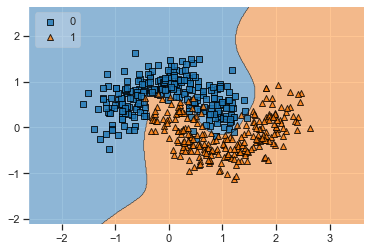

In [13]:
pipe.fit(X, y)
plot_decision_regions(X, y, clf=pipe, legend=2)
plt.show()

## Three Hidden Layers

In [14]:
mlp_sklearn = MLPClassifier(
    hidden_layer_sizes=(10, 20, 30,),
    activation='logistic',
    solver='lbfgs',
    alpha=1e-2,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.10,
    n_iter_no_change=10,
    max_iter=200,
    tol=1e-4
)

scaler = StandardScaler()
pipe = make_pipeline(scaler, mlp_sklearn)

scores = cross_val_score(pipe, X, y, cv=5, n_jobs=-1, scoring='roc_auc')
scores.mean(), scores.std()

(0.9856000000000001, 0.009121403400793097)

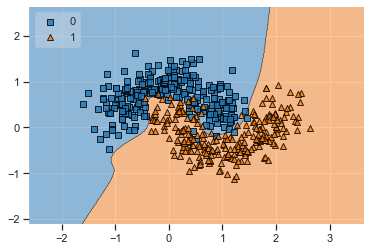

In [15]:
pipe.fit(X, y)
plot_decision_regions(X, y, clf=pipe, legend=2)
plt.show()

## Four Hidden Layers

In [16]:
mlp_sklearn = MLPClassifier(
    hidden_layer_sizes=(10, 20, 30, 40,),
    activation='logistic',
    solver='lbfgs',
    alpha=1e-2,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.10,
    n_iter_no_change=10,
    max_iter=200,
    tol=1e-4
)

scaler = StandardScaler()
pipe = make_pipeline(scaler, mlp_sklearn)

scores = cross_val_score(pipe, X, y, cv=5, n_jobs=-1, scoring='roc_auc')
scores.mean(), scores.std()

(0.9132, 0.09793124118482313)

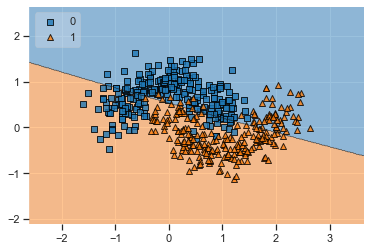

In [17]:
pipe.fit(X, y)
plot_decision_regions(X, y, clf=pipe, legend=2)
plt.show()

# PyTorch MLP (w/ Skorch)

## Classifier Object

In [18]:
class ClassifierModule(nn.Module):
    def __init__(self, p=0.1, nonlin=F.leaky_relu):
        super(ClassifierModule, self).__init__()
        
        # Network Topology:
        # 2 inputs |--> 10 nodes |--> 20 nodes |--> 2 outputs
        
        self.dense0 = nn.Linear(2, 10)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(p)
        self.dense1 = nn.Linear(10, 20)
        self.output = nn.Linear(20, 2)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = F.relu(self.dense1(X))
        X = F.softmax(self.output(X))
        return X


## Initializing the Skorch NN

In [19]:
torch.manual_seed(0)
auc = EpochScoring(scoring='roc_auc', lower_is_better=False)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=200,
    lr=0.5,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    verbose=False,
#     callbacks=[auc],
)

## Pipeline w/ Skorch NN

In [20]:
X = df[used_cols].values.astype(np.float32)
y = df[target].values.astype(np.int64)

scaler = StandardScaler()
pipe = make_pipeline(scaler, net)

## Training

In [21]:
pipe.fit(X, y)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('neuralnetclassifier',
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassifierModule(
    (dense0): Linear(in_features=2, out_features=10, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (dense1): Linear(in_features=10, out_features=20, bias=True)
    (output): Linear(in_features=20, out_features=2, bias=True)
  ),
))],
         verbose=False)

## Evaluation

### Training/Validation Loss

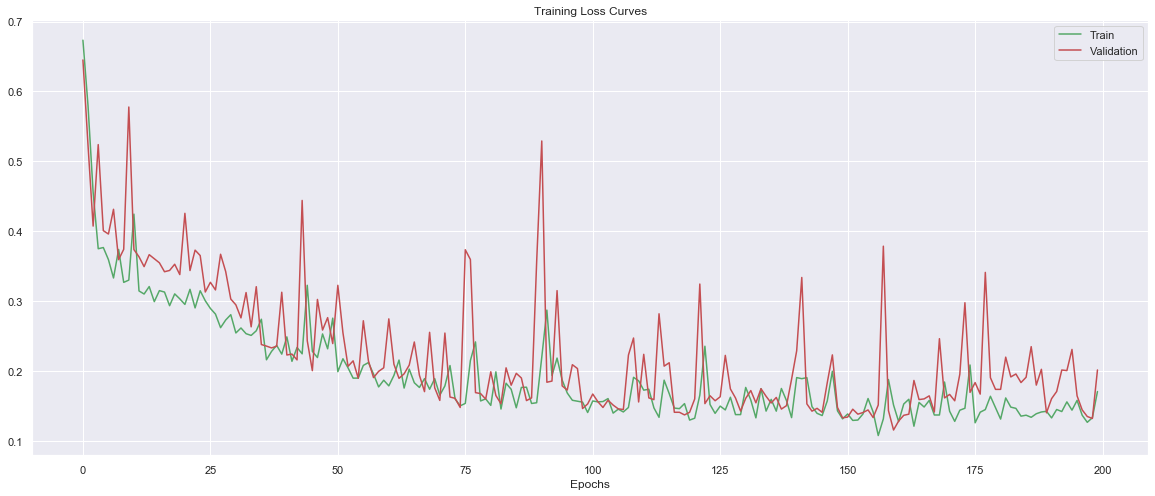

In [22]:
clf = pipe.steps[-1][1]

epochs = [i for i in range(len(clf.history))]
train_loss = clf.history[:,'train_loss']
valid_loss = clf.history[:,'valid_loss']

plt.figure(figsize=(20,8))
plt.plot(epochs,train_loss,'g-');
plt.plot(epochs,valid_loss,'r-');
plt.title('Training Loss Curves');
plt.xlabel('Epochs');
plt.legend(['Train','Validation']);
plt.show()

### Cross Validation

In [23]:
# scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
# scores.mean(), scores.std()

(0.98752, 0.005321052527461044)

### Visualizing the Decision Boundary

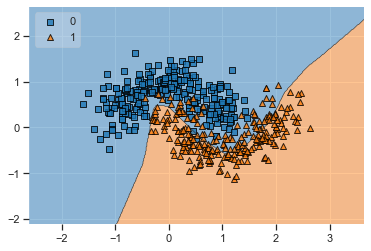

In [24]:
pipe.fit(X, y)
plot_decision_regions(X, y, clf=pipe, legend=2)
plt.show()

# References / Resources

## MLPs

* https://en.wikipedia.org/wiki/Multilayer_perceptron

* https://www.ling.upenn.edu/courses/cogs501/Rosenblatt1958.pdf

## Implementations

* SciKit-Learn: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.neural_network

* Torch: https://github.com/pytorch/pytorch

* Skorch: https://github.com/skorch-dev/skorch

* TensorFlow: https://github.com/tensorflow/tensorflow

* Keras: https://github.com/keras-team/keras

## Gradient Descent Issues

* Vanishing Gradient Problem: https://en.wikipedia.org/wiki/Vanishing_gradient_problem

* Exploding Gradient Problem: https://machinelearningmastery.com/exploding-gradients-in-neural-networks/

## Activation Functions

* RELU: http://www.bioguider.com/ebook/biology/pdf/hahnloser_n947.pdf

* Leaky-RELU: https://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf

* ELU: https://arxiv.org/pdf/1511.07289.pdf

* GELU: https://arxiv.org/pdf/1606.08415.pdf

* SELU: https://arxiv.org/pdf/1706.02515.pdf

* CELU: https://arxiv.org/pdf/1704.07483.pdf

## Dropout

* https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf

## Tips and Tricks

* Stanford (CS 230 - Deep Learning): https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-deep-learning-tips-and-tricks#good-practices

## Neural Net Zoo

* https://www.asimovinstitute.org/neural-network-zoo/

## Model Zoo

* https://modelzoo.co/

## Google Colab (w/ Free GPUs)

* https://colab.research.google.com/notebooks/welcome.ipynb